## Live Fish Fish Analysis

### Import Data

In [2]:
import math
import glob

import h5py

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import losses
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import rc, cm
from matplotlib.pyplot import subplots
from matplotlib.animation import FuncAnimation
from IPython import display
import pandas as pd
plt.rcParams['animation.ffmpeg_path'] = '/home/mi/chanakya/.conda/envs/py_36/bin/ffmpeg'
print("Version:", tf.__version__)

Version: 2.1.0


### Data Import and Trajectory Creation

In [3]:
def transform_coordinates(state):
  # state has x , y, dx ,dy 
    state_ = np.zeros_like(state)
    state_[:, :, 0] = state[:, :, 0] - 50
    state_[:, :, 1] = - state[:, :, 1] + 50
    state_[:, :, 2] = state[:, :, 2]
    state_[:, :, 3] = - state[:, :, 3]
    return state_

In [4]:
def return_speeds(current_state, previous_state, max_speed, max_ang_velo):
    speed = np.sqrt((current_state[0] - previous_state[0])**2 + (current_state[1] - previous_state[1])**2)
    speed = min(speed, max_speed)
    angular_velocity = np.arctan2(current_state[3], current_state[2]) - np.arctan2(previous_state[3], previous_state[2])
    if angular_velocity > np.pi:
        angular_velocity = angular_velocity - 2 * np.pi
    if angular_velocity < -np.pi:
        angular_velocity = angular_velocity + 2 * np.pi
    
    angular_velocity = min(angular_velocity, max_ang_velo) * (angular_velocity >= 0) + max(angular_velocity, -max_ang_velo) * (angular_velocity < 0)
    return speed, angular_velocity

In [4]:
def import_data(path, random, no_of_trajectories, transform):
    
    if random == 1:
        random_selection = np.random.randint(0,np.shape(path)[0], no_of_trajectories)
    else:
        random_selection = np.array(range(len(path)))
    
    agents = []
    actual_no_of_agents = 0
    
    for j in random_selection:
        agents.append([])
        
    for j, p in zip(random_selection, range(len(random_selection))):
        
        hf = h5py.File(path[j], 'r')
        keys = list(hf.keys())
        
        for k in range(len(keys)):
            
            agents[p].append(np.asarray(hf.get(keys[k])))
            actual_no_of_agents += 1
        
        if transform == 1:
            agents[p] = transform_coordinates(np.asarray(agents[p]))
        else:
            agents[p] = np.asarray(agents[p])
            
    for j in range(len(agents) - 1):
        agents[0] = np.append(agents[0], agents[j+1], axis = 0)
        
    return agents[0]

In [10]:
training_data_type = int(input("Enter 0 for Couzin Tourus and 1 for Live Female Female:"))

train_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/train/*.hdf5")
test_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/test/*.hdf5")
validation_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/validation/*.hdf5")

train_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/train/*.hdf5")
test_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/test/*.hdf5")
validation_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/validation/*.hdf5")

if training_data_type == 0:
    train_path = train_path_couzin_torus
    test_path = test_path_couzin_torus
    validation_path = validation_path_couzin_torus
else:
    train_path = train_path_live_female_female
    test_path = test_path_live_female_female
    validation_path = validation_path_live_female_female

for i in range(len(train_path)):
    train_path[i] = train_path[i].replace("\\", "/")
for i in range(len(test_path)):
    test_path[i] = test_path[i].replace("\\", "/")
for i in range(len(validation_path)):
    validation_path[i] = validation_path[i].replace("\\", "/")
    
# Wall, raycast parameters
if training_data_type == 0:
    
    max_dist = np.sqrt(100*100*2)    

    no_of_bins_voa = 21
    total_angle_voa = np.pi * 300 / 180

    no_of_bins_vow = 15
    total_angle_vow = np.pi
    wall_boundaries = np.array([50, -50, 50, -50])

    max_speed = 0.64
    speed_bins = 41
    max_ang_velo = 1.5
    ang_vel_bins = 217

else:
    
    max_dist = np.sqrt(100*100*2)    

    no_of_bins_voa = 151
    total_angle_voa = np.pi * 300 / 180

    no_of_bins_vow = 151
    total_angle_vow = np.pi * 298 / 180
    wall_boundaries = np.array([50, -50, 50, -50])

    max_speed = 0.8
    no_speed_bins = 215
    max_ang_velo = 0.8
    ang_vel_bins = 215

model_time_steps = 75 

Enter 0 for Couzin Tourus and 1 for Live Female Female:1


### Evaluation

In [13]:
data_2_fish = import_data(train_path, 0,1,1)

In [34]:
speed = []
ang_vel = []
for i in range(np.shape(data_2_fish)[0]):
    for j in range(np.shape(data_2_fish)[1] - 1):
        speeds, vel = return_speeds(data_2_fish[i, j + 1, :], data_2_fish[i, j, :], max_speed, max_ang_velo)
        speed.append(speeds)
        ang_vel.append(vel)

In [14]:
vel_ang_binned = np.zeros(ang_vel_bins)
speed_binned = np.zeros(no_speed_bins)
speed_bins = np.array(range(-no_speed_bins, no_speed_bins + 1 , 2)) * max_speed / (no_speed_bins - 1) 
vel_ang_bins = np.array(range(-ang_vel_bins, ang_vel_bins + 1, 2)) * max_ang_velo / (ang_vel_bins - 1) 

In [ ]:
for i in range(np.shape(data_2_fish)[0]):
    print(i)
    for j in range(np.shape(data_2_fish)[1] - 1):
#         print(i,j)
        speeds, vel = return_speeds(data_2_fish[i, j + 1, :], data_2_fish[i, j, :], max_speed, max_ang_velo)
        
        for p in range(no_speed_bins):
            if speeds > speed_bins[p] and speeds < speed_bins[p + 1]:
                speed_binned[p] += 1

        for p in range(ang_vel_bins):
            if vel > vel_ang_bins[p] and vel < vel_ang_bins[p + 1]:
                vel_ang_binned[p] += 1

### Graphs

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 14603., 20001., 17093., 14431., 

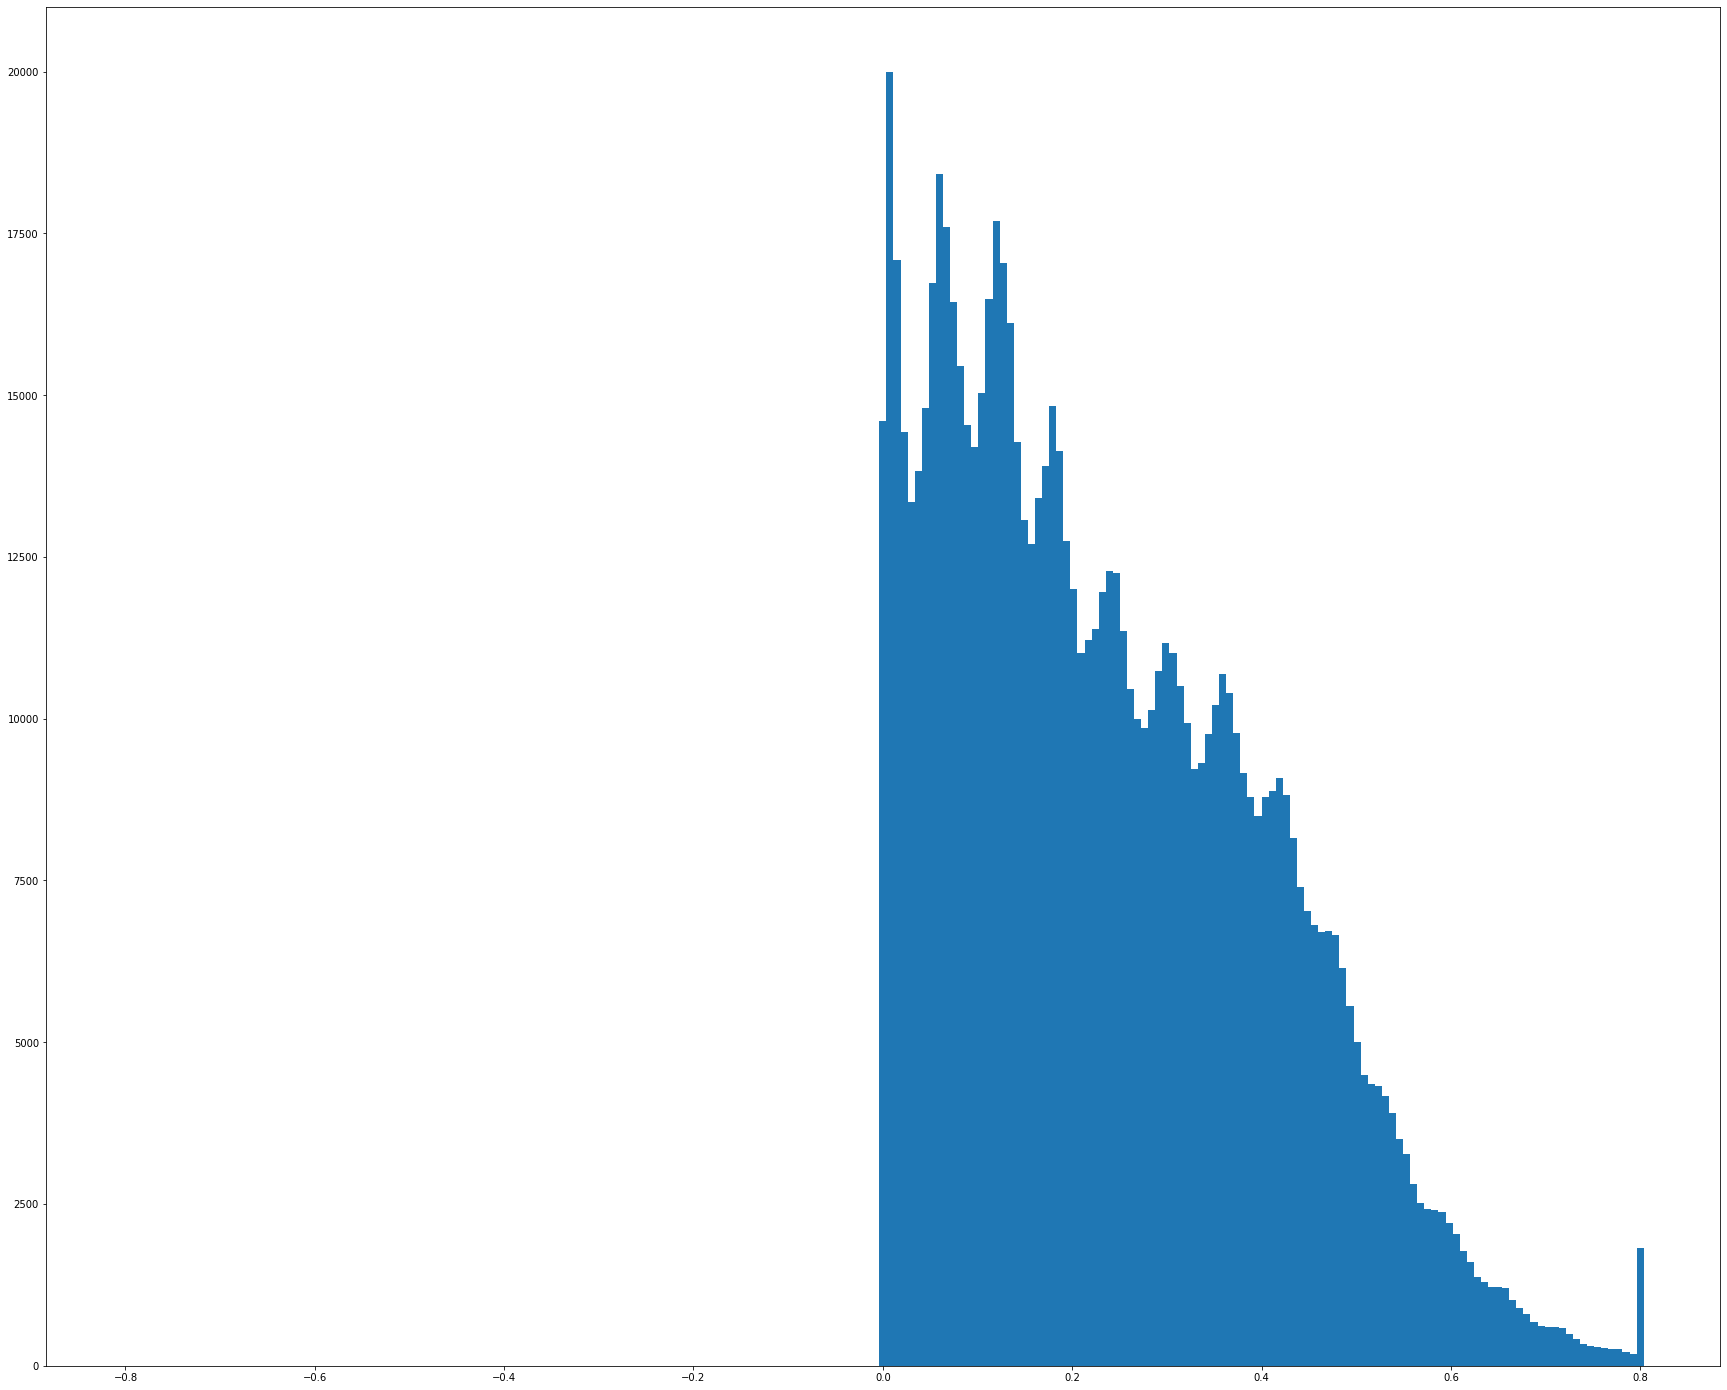

In [36]:
plt.rcParams["figure.figsize"] = (30,25)
plt.hist(speed, bins = speed_bins)

(array([4.6440e+03, 1.8000e+01, 2.4000e+01, 2.9000e+01, 2.8000e+01,
        3.0000e+01, 2.7000e+01, 2.3000e+01, 2.7000e+01, 4.0000e+01,
        3.2000e+01, 3.8000e+01, 3.1000e+01, 4.5000e+01, 5.5000e+01,
        4.9000e+01, 4.8000e+01, 4.3000e+01, 4.5000e+01, 5.7000e+01,
        4.7000e+01, 6.1000e+01, 6.6000e+01, 6.1000e+01, 8.5000e+01,
        7.0000e+01, 8.4000e+01, 8.4000e+01, 8.7000e+01, 9.5000e+01,
        1.0400e+02, 1.1200e+02, 1.1400e+02, 1.0900e+02, 1.2200e+02,
        1.3200e+02, 1.2900e+02, 1.4600e+02, 1.4000e+02, 1.5700e+02,
        1.5400e+02, 1.3900e+02, 1.5700e+02, 1.6300e+02, 1.7500e+02,
        2.2800e+02, 2.1900e+02, 1.7600e+02, 1.8700e+02, 2.3800e+02,
        2.5400e+02, 2.4300e+02, 2.4700e+02, 2.7400e+02, 3.0000e+02,
        3.0800e+02, 3.0900e+02, 3.9500e+02, 3.8900e+02, 4.2600e+02,
        4.3400e+02, 4.4700e+02, 4.8700e+02, 5.4900e+02, 5.9400e+02,
        6.0400e+02, 6.7800e+02, 7.1000e+02, 7.6200e+02, 8.0800e+02,
        9.6500e+02, 1.0190e+03, 1.1830e+03, 1.21

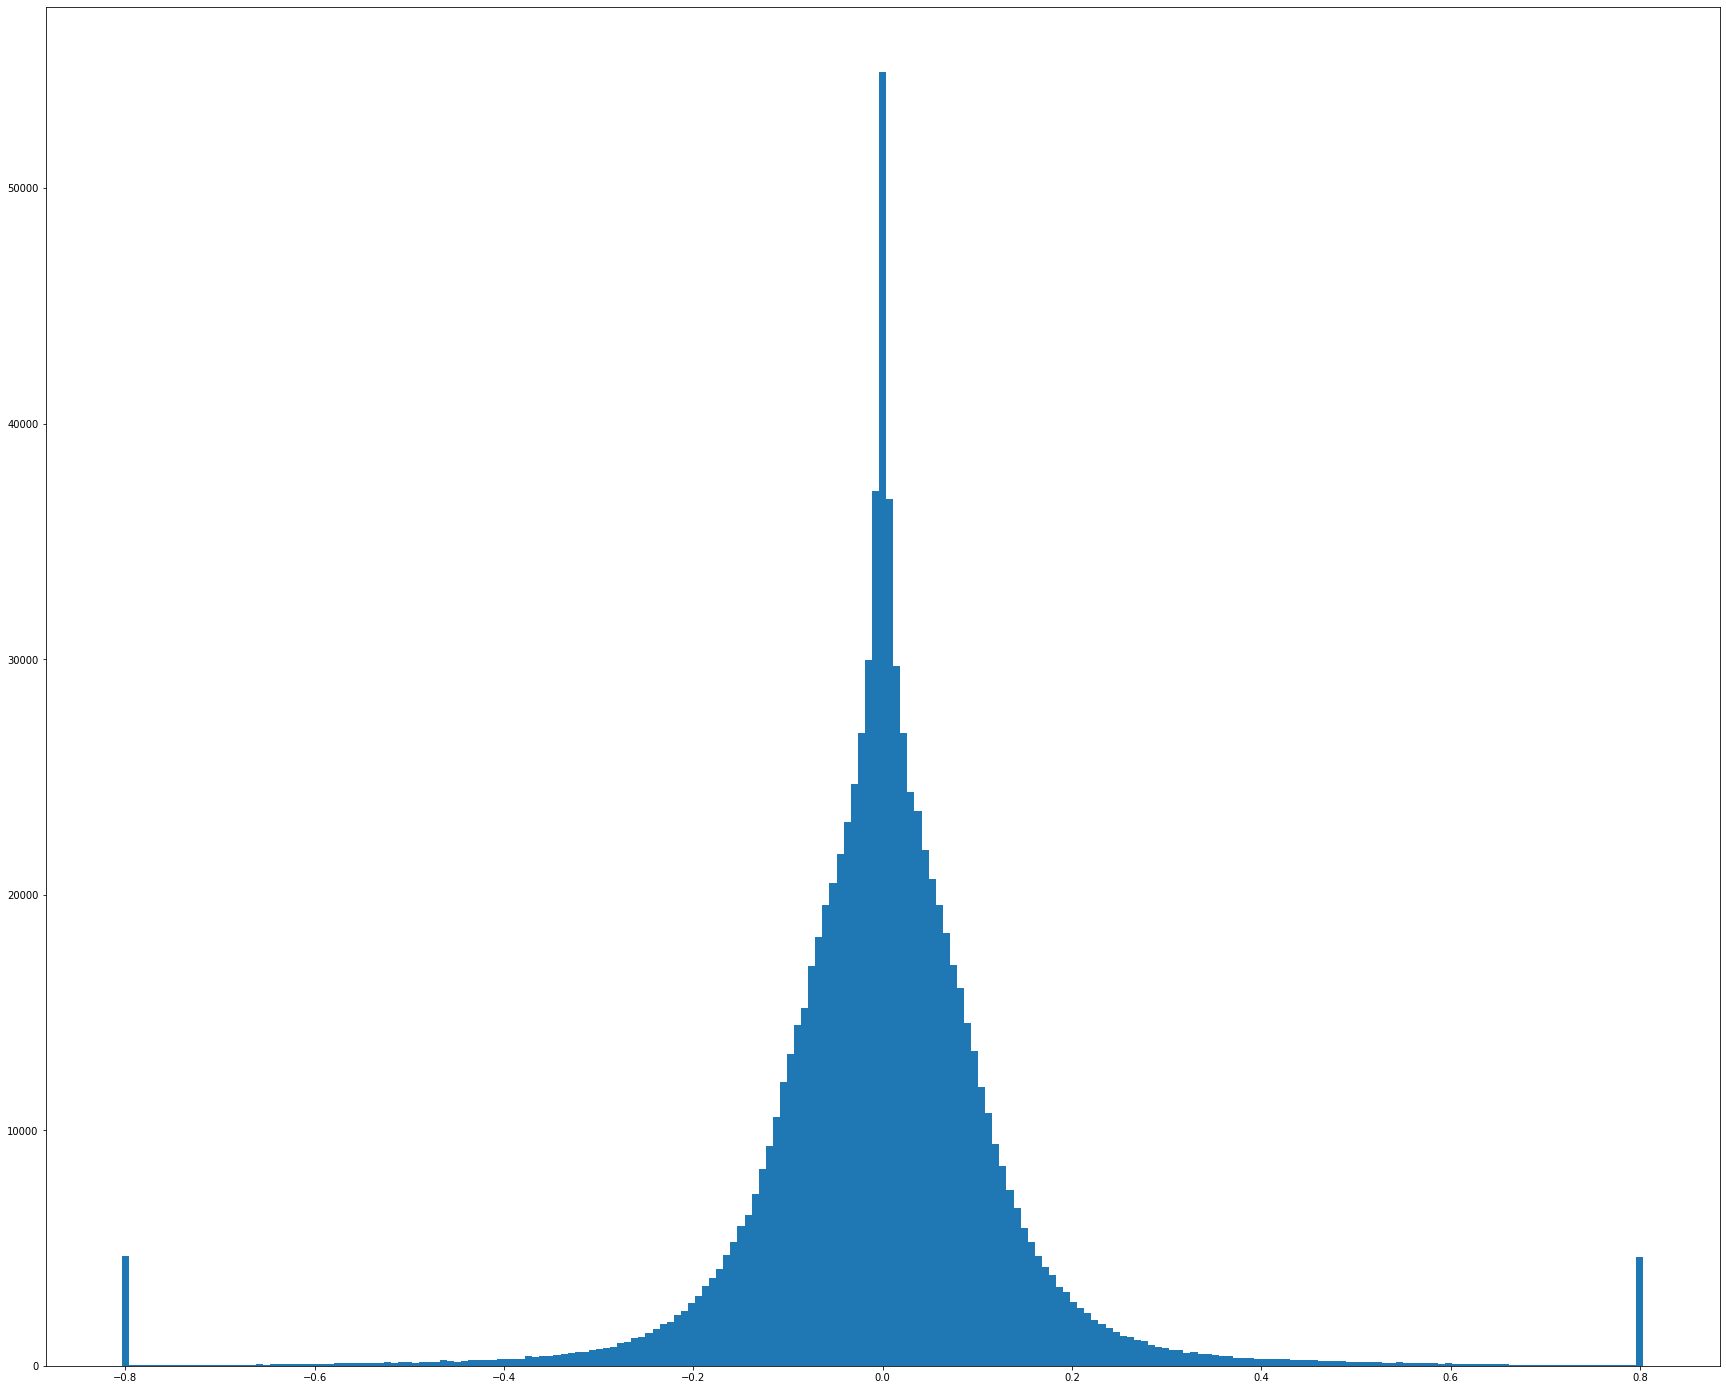

In [37]:
plt.hist(ang_vel, bins = vel_ang_bins)

## Guppy Gym Analysis

### Importing Data

In [18]:
def import_data_csv_gg(path, random, no_of_trajectories):
    
    if random == 1:
        random_selection = np.random.randint(0,np.shape(path)[0], no_of_trajectories)
    else:
        random_selection = np.array(range(len(path)))

    agents = []
    
    for j, p in zip(random_selection, range(len(random_selection))):

        data = np.asarray(pd.read_csv(path[random_selection[p]]))
        data_proc = np.zeros((int(np.shape(data)[1] / 4), np.shape(data)[0], 4))

        for k in range(np.shape(data_proc)[0]):
            data_proc[k, :, :] = data[:, (4*k):(4*(k+1))]

        agents.append(data_proc)
        
    for j in range(np.shape(path)[0] - 1):
        agents[0] = np.append(agents[0], agents[j+1], axis = 0)
        
    return agents[0]

In [81]:
data_type = int(input("Enter 0 for Couzin Data, 1 for Adaptive Guppy Gym Data and 2 for Live Fish Fish:"))
training_data_type = int(input("Enter 0 for a normal LSTM Network and 1 for the Ladder Network:"))

train_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/train/*.hdf5")
test_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/test/*.hdf5")
validation_path_couzin_torus = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/couzin_torus/validation/*.hdf5")

train_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/train/*.hdf5")
test_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/test/*.hdf5")
validation_path_live_female_female = glob.glob("/home/mi/chanakya/learn_fish_models/Datasets/datasets/live_female_female/validation/*.hdf5")

train_path_guppy_gym = glob.glob('/home/mi/chanakya/gym-guppy/data/train/*.csv')
test_path_guppy_gym = glob.glob('/home/mi/chanakya/gym-guppy/data/test/*.csv')
validation_path_guppy_gym = glob.glob('/home/mi/chanakya/gym-guppy/data/validate/*.csv')

include_data_rf = int(input("Enter 1 for using the Robot Fish Interaction Data:"))

if include_data_rf == 1:
    path_csv_rf = glob.glob("/home/mi/chanakya/input_data/2018/P_Trials/Adaptive/*.csv")
    train_path_rf = path_csv_rf[0:17]
    test_path_rf = path[17:20]
    validation_path_rf = path[20:23]

if data_type == 0:
    train_path = train_path_couzin_torus
    test_path = test_path_couzin_torus
    validation_path = validation_path_couzin_torus
elif data_type == 1:
    train_path = train_path_guppy_gym
    test_path = test_path_guppy_gym
    validation_path = validation_path_guppy_gym
elif data_type == 2:
    train_path = train_path_live_female_female
    test_path = test_path_live_female_female
    validation_path = validation_path_live_female_female

for i in range(len(train_path)):
    train_path[i] = train_path[i].replace("\\", "/")
for i in range(len(test_path)):
    test_path[i] = test_path[i].replace("\\", "/")
for i in range(len(validation_path)):
    validation_path[i] = validation_path[i].replace("\\", "/")
    
# Wall, raycast parameters
if training_data_type == 0:
    
    max_dist = np.sqrt(100*100*2)    

    no_of_bins_voa = 21
    total_angle_voa = np.pi

    no_of_bins_vow = 15
    total_angle_vow = np.pi
    wall_boundaries = np.array([50, -50, 50, -50])

    max_speed = 0.32
    speed_bins = 41
    max_ang_velo = 0.75
    ang_vel_bins = 217

else:
    
    max_dist = np.sqrt(100*100*2)    

    no_of_bins_voa = 151
    total_angle_voa = np.pi * 300 / 180

    no_of_bins_vow = 151
    total_angle_vow = np.pi * 298 / 180
    wall_boundaries = np.array([50, -50, 50, -50])

    max_speed = 0.8
    speed_bins = 215
    max_ang_velo = 0.8
    ang_vel_bins = 215

Enter 0 for Couzin Data, 1 for Adaptive Guppy Gym Data and 2 for Live Fish Fish:1
Enter 0 for a normal LSTM Network and 1 for the Ladder Network:1
Enter 1 for using the Robot Fish Interaction Data:0


In [82]:
data_fish = import_data_csv_gg(train_path, 0,1)
speed = []
ang_vel = []
for i in range(np.shape(data_fish)[0]):
    for j in range(np.shape(data_fish)[1] - 1):
        speeds, vel = return_speeds(data_fish[i, j + 1, :], data_fish[i, j, :], max_speed, max_ang_velo)
        speed.append(speeds)
        ang_vel.append(vel)

In [83]:
speed_bins = np.array(range(-speed_bins, speed_bins + 1 , 2)) * max_speed / (speed_bins - 1) 
vel_ang_bins = np.array(range(-ang_vel_bins, ang_vel_bins + 1, 2)) * max_ang_velo / (ang_vel_bins - 1) 

### Graphs

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

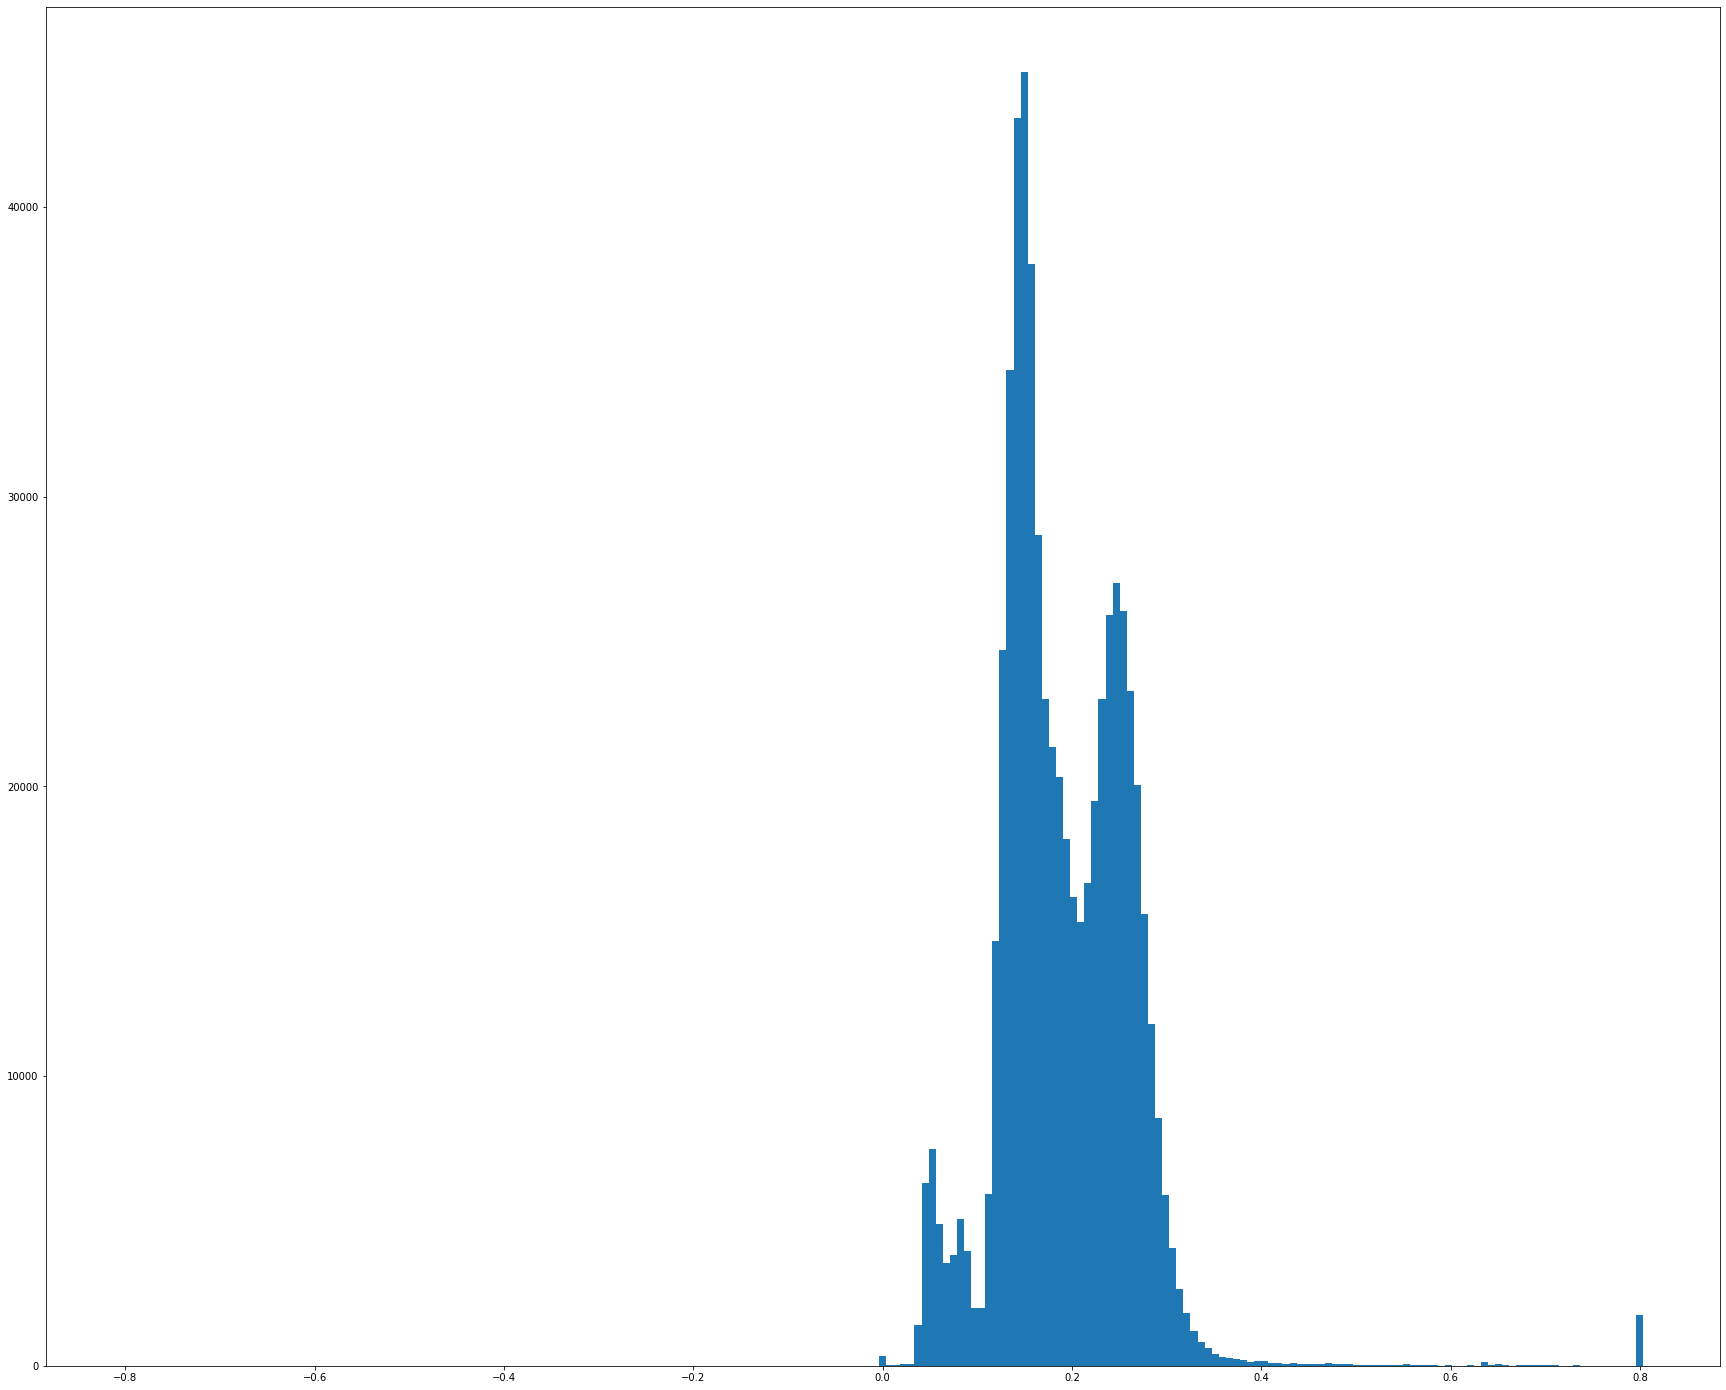

In [84]:
plt.rcParams["figure.figsize"] = (30,25)
plt.hist(speed, bins = speed_bins)

(array([3.73900e+03, 3.20000e+01, 4.90000e+01, 4.70000e+01, 4.50000e+01,
        4.30000e+01, 5.00000e+01, 3.20000e+01, 4.10000e+01, 4.50000e+01,
        3.60000e+01, 3.60000e+01, 3.60000e+01, 4.70000e+01, 5.30000e+01,
        4.70000e+01, 4.90000e+01, 4.00000e+01, 5.80000e+01, 4.50000e+01,
        5.10000e+01, 4.30000e+01, 3.80000e+01, 5.50000e+01, 4.70000e+01,
        5.10000e+01, 5.40000e+01, 6.30000e+01, 5.00000e+01, 6.00000e+01,
        6.90000e+01, 6.20000e+01, 6.20000e+01, 6.60000e+01, 7.90000e+01,
        5.40000e+01, 6.90000e+01, 7.00000e+01, 8.70000e+01, 7.00000e+01,
        8.40000e+01, 7.90000e+01, 7.30000e+01, 7.20000e+01, 9.90000e+01,
        9.00000e+01, 1.08000e+02, 1.02000e+02, 9.20000e+01, 1.05000e+02,
        1.37000e+02, 1.15000e+02, 1.31000e+02, 1.41000e+02, 1.64000e+02,
        1.73000e+02, 1.71000e+02, 2.01000e+02, 2.11000e+02, 2.10000e+02,
        2.59000e+02, 3.04000e+02, 3.25000e+02, 3.10000e+02, 3.83000e+02,
        4.58000e+02, 4.50000e+02, 5.37000e+02, 5.52

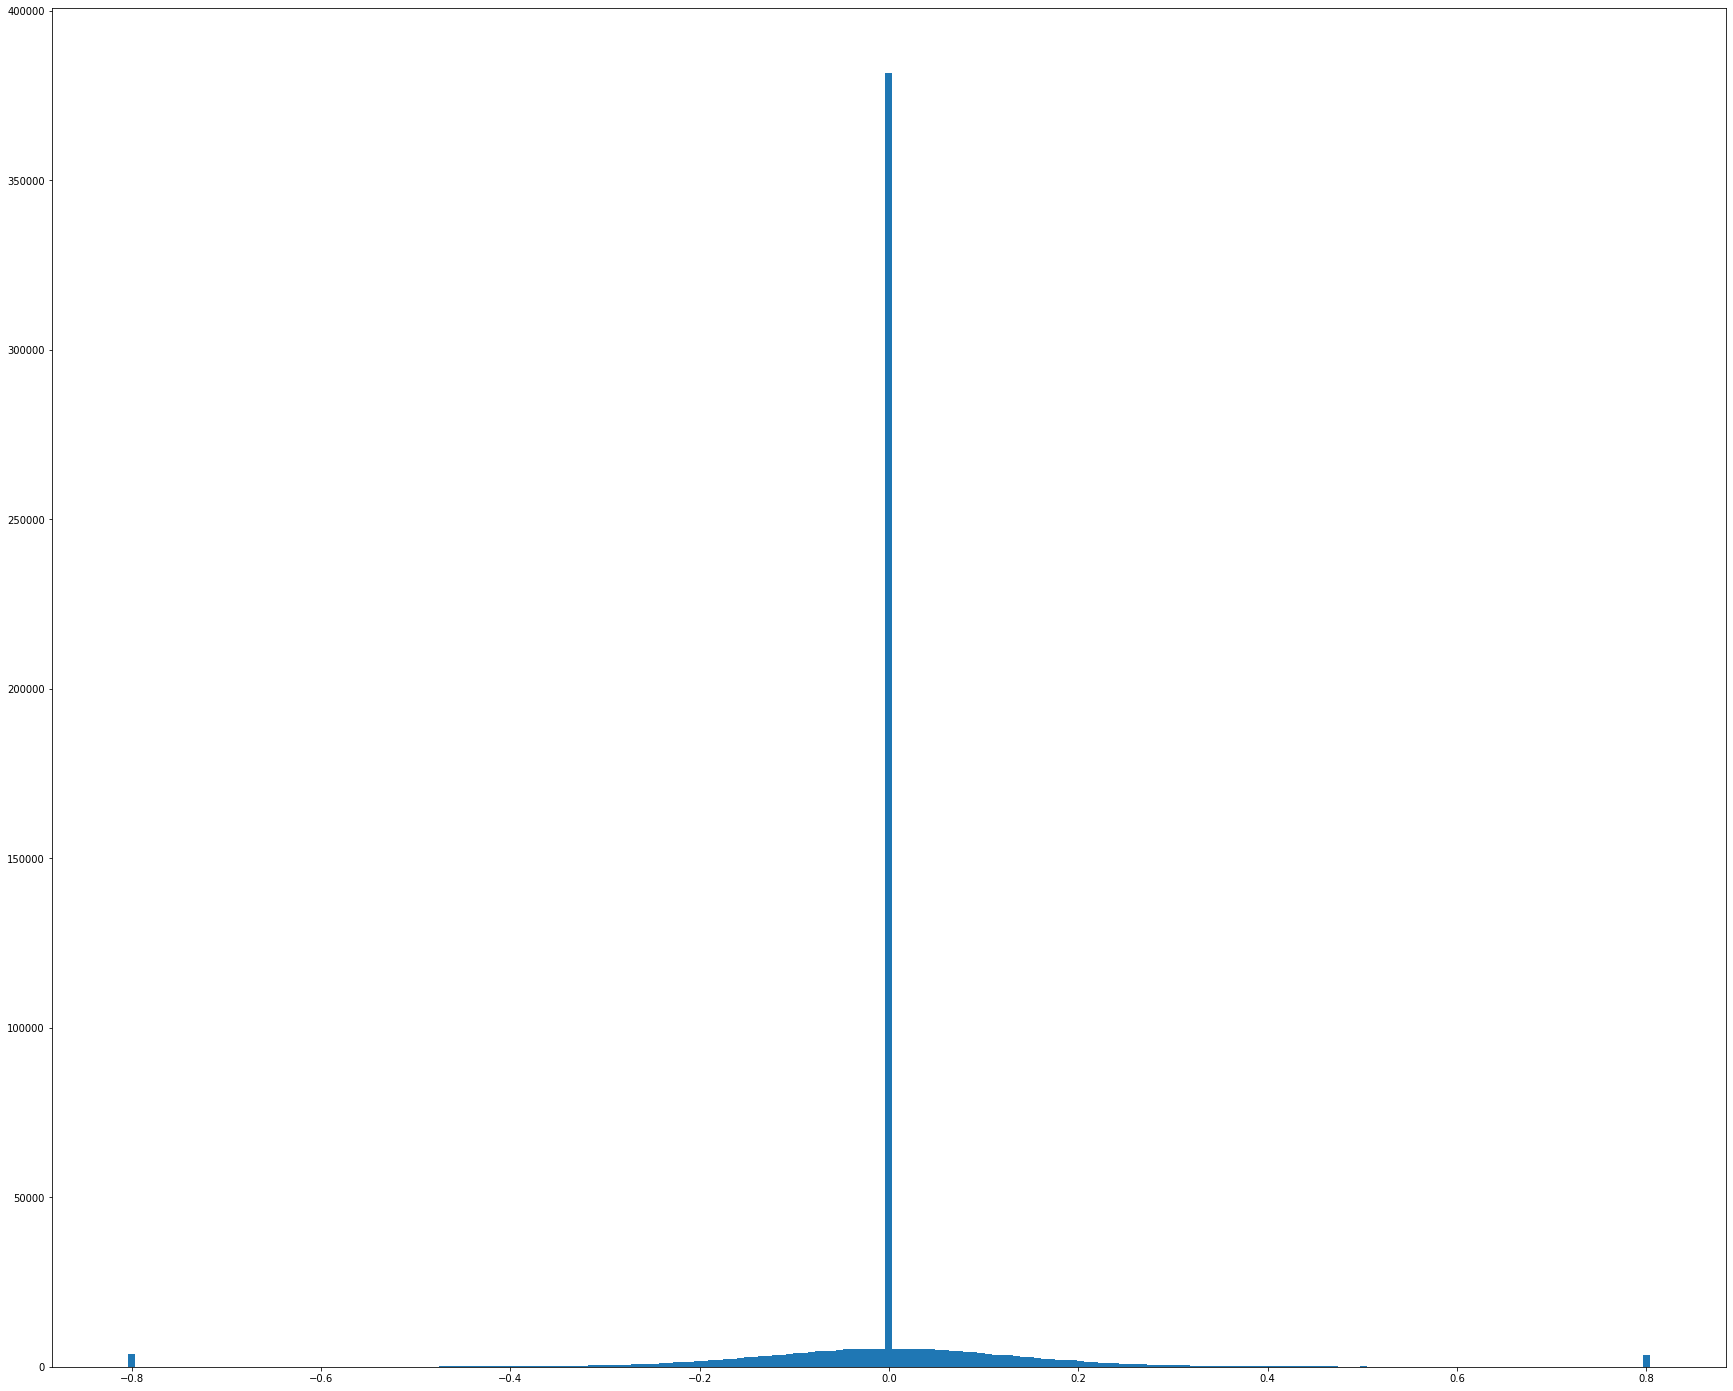

In [85]:
plt.hist(ang_vel, bins = vel_ang_bins)

In [94]:
no_speed_bins = 215
vel_ang_binned = np.zeros(ang_vel_bins)
speed_binned = np.zeros(no_speed_bins)
for i in range(np.shape(data_fish)[0]):
    for j in range(np.shape(data_fish)[1] - 1):
#         print(i,j)
        speeds, vel = return_speeds(data_fish[i, j + 1, :], data_fish[i, j, :], max_speed, max_ang_velo)
        
        for p in range(no_speed_bins):
            if speeds > speed_bins[p] and speeds < speed_bins[p + 1]:
                speed_binned[p] += 1

        for p in range(ang_vel_bins):
            if vel > vel_ang_bins[p] and vel < vel_ang_bins[p + 1]:
                vel_ang_binned[p] += 1

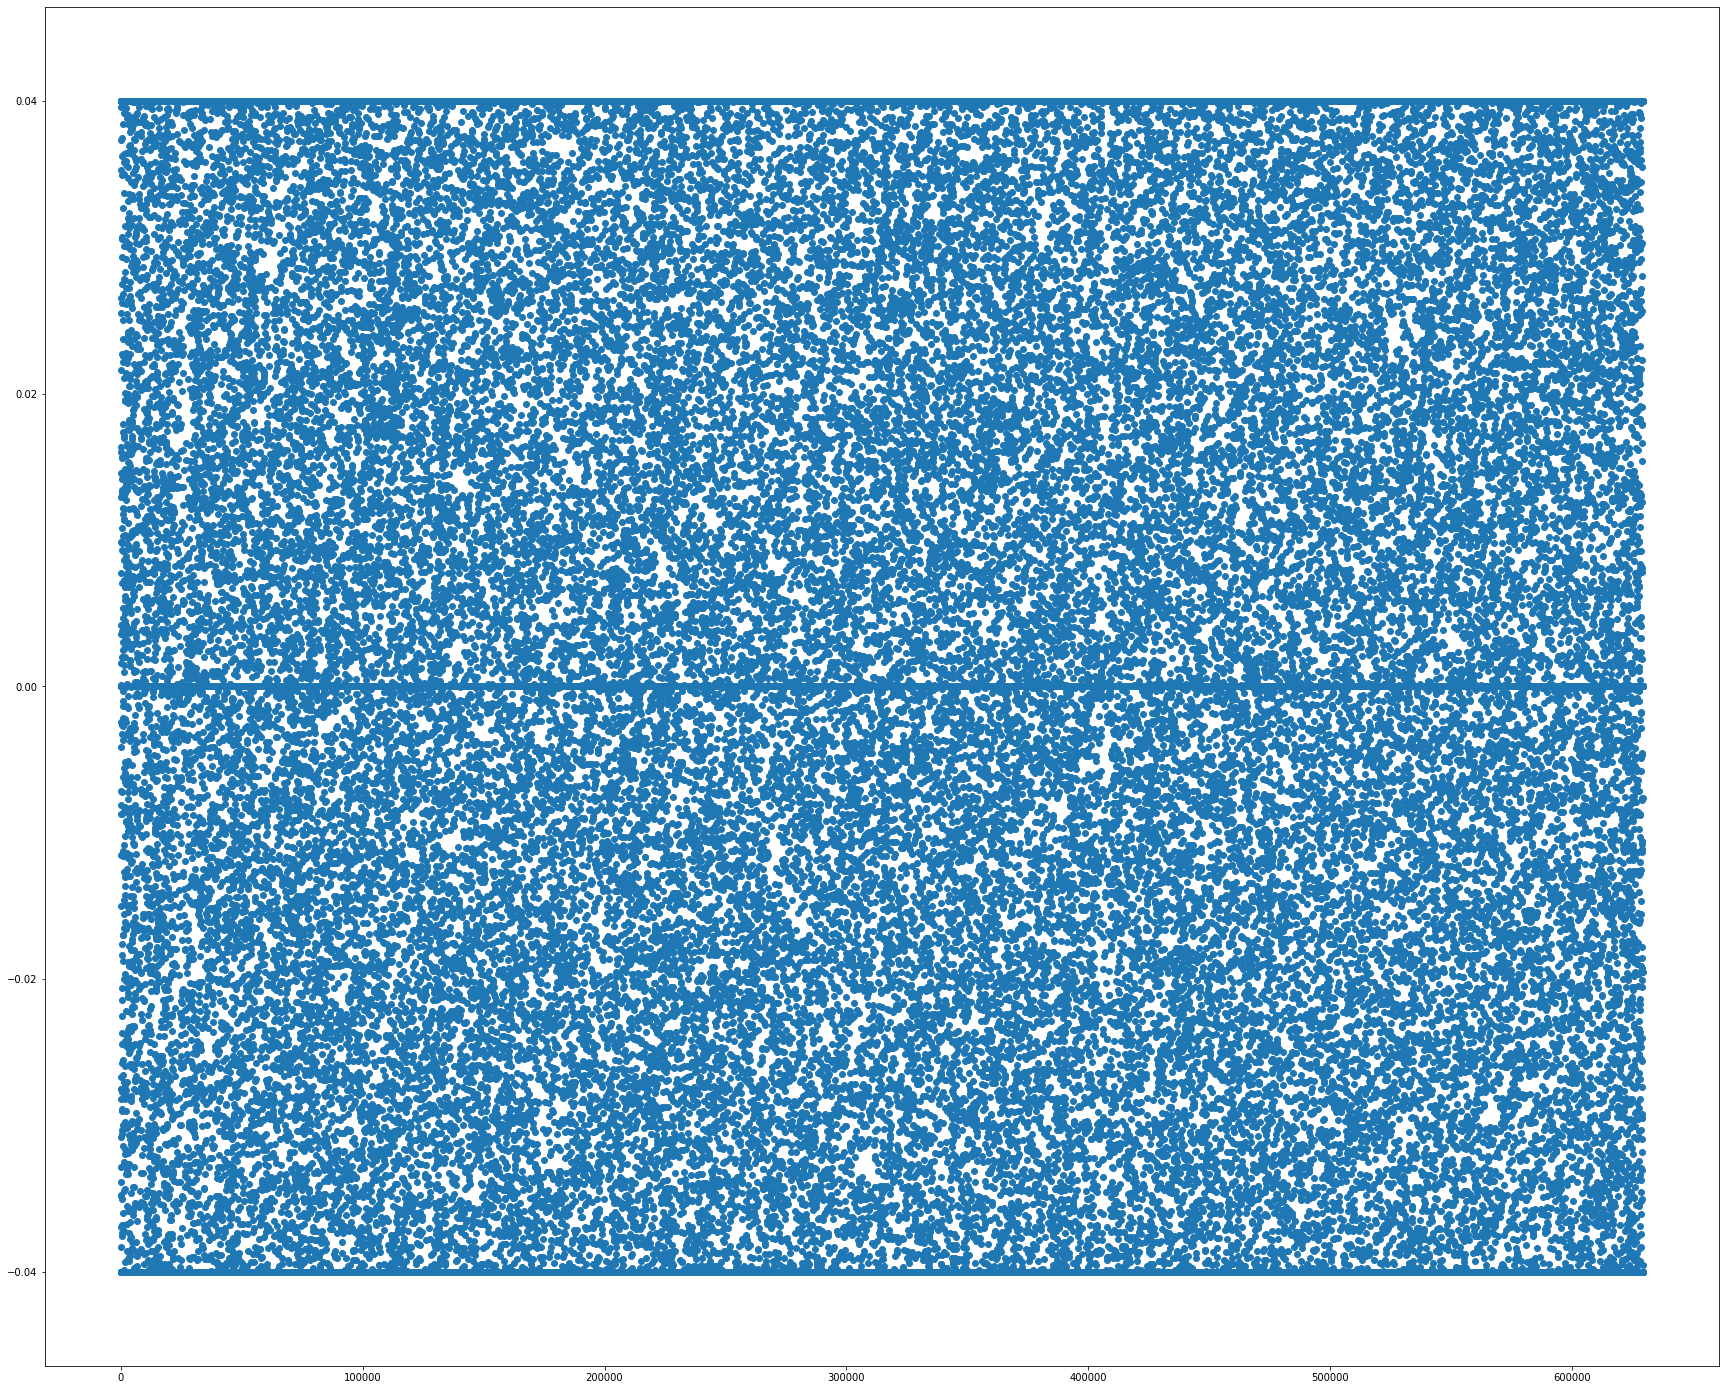

In [71]:
plt.scatter(range(len(ang_vel)), ang_vel)
